In [34]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [35]:
import supervillain

# Introduction

In this notebook we will run two short ensembles with different parameters for a relatively small lattice.

In [36]:
N = 5
L = supervillain.lattice.Lattice2D(N)
configurations = 1000

Including how to do i/o with hdf5

In [37]:
import h5py as h5
storage = 'compare-and-contrast.h5'
# We first remove the storage, so that the examples can run all the way through.
with h5.File(storage, 'w') as f:
    pass

and how to do a simple bootstrap analysis.

In [38]:
bootstrap_resampling = 100

The purpose is to show a relatively complete analysis for both the Villain and Worldline formulations.

To check that the two formulations agree, you can run them with the same parameters using `examples/action-comparison.py`.

Instead, here we run with two different parameters, the Villain formulation in the small-κ regime and the Worldline formulation in the large-κ regime.  It is in these regimes where each formulation does well.

# Understanding Results

We might like to look at Monte Carlo histories to see that our observables are fluctuating well.

In [39]:
def plot_history(
        axs, index, data,
        label=None,
        bins=31, density=True,
        alpha=0.5, color=None
        ):
    r'''
    axs is a numpy array of at least 2 matplotlib axes.
    In the first goes the Monte Carlo history; in the second goes the corresponding histogram.
    '''
    
    axs[0].plot(index, data, color=color, alpha=alpha)
    axs[1].hist(data, label=label,
            orientation='horizontal',
            bins=bins, density=density,
            color=color, alpha=alpha,)
    
    
def plot(ensemble, ax=None):
    r'''
    Takes an ensemble and an optional set of axes.
    If the axes are not provided, creates a new figure for plotting Monte Carlo histories.
    If the axes are provided, plots Monte Carlo histories on those axes.
    '''
    if ax is None:
        _, ax = plt.subplots(2,2,
            figsize=(10, 6),
            gridspec_kw={'width_ratios': [4, 1], 'wspace': 0},
            sharey='row',
            squeeze=False
        )

    plot_history(ax[0], ensemble.index, ensemble.InternalEnergyDensity)
    plot_history(ax[1], ensemble.index, ensemble.WindingSquared)

    ax[0,0].set_ylabel('U / Λ')
    ax[1,0].set_ylabel('w^2')
    ax[-1,0].set_xlabel('Monte Carlo time')
    
    return ax

We can compute a quick-and-dirty naive error estimate from a Markov chain directly.

In [40]:
def naive_estimate(observable):
    # (mean, uncertainty)
    return (np.mean(observable), np.std(observable) / np.sqrt(len(observable)))    

`supervilllain` provides infrastructure for bootstrap resampling.  To actually get central values and uncertainties we need to reduce by taking the mean and standard deviation of the resampled means.

In [41]:
def bootstrap_estimate(observable):
    # (mean, uncertainty)
    return (np.mean(observable), np.std(observable))

def error_format(estimate):
    mean = estimate[0]
    err  = estimate[1]
    return f'{mean:.3f} ± {err:.3f}'

We might also want to draw the uncertainties as error bands.

In [42]:
def band(ax, estimate, color=None):
    mean = estimate[0]
    err  = estimate[1]
    if color is None:
        color = ax.get_lines()[-1].get_color()
    ax.axhspan(mean-err, mean+err, color=color, alpha=0.5, linestyle='none')

# Villain Formulation

The Villain formulation is best when κ is small.  Since κ lives upstairs in the action, a small action allows easier transitions and yields more likely acceptance for local proposals.

In [43]:
kappa = 0.1
S = supervillain.Villain(L, kappa)

We use a simple single-site (and adjoining link) update.

In [44]:
G = supervillain.generator.NeighborhoodUpdate(S)
v = supervillain.Ensemble(S).generate(configurations, G, start='cold', progress=tqdm)

  0%|          | 0/999 [00:00<?, ?it/s]

In [45]:
print(G.report())
print(f'S/Λ    {error_format(naive_estimate(v.InternalEnergyDensity))}')
print(f'dn^2   {error_format(naive_estimate(v.WindingSquared))}')

autocorrelation = max([
    supervillain.analysis.autocorrelation_time(o)
    for o in (v.InternalEnergyDensity, v.WindingSquared)])

print(f'τ      {autocorrelation}')

There were 3070 single-site proposals accepted of 25000 proposed updates.
    0.122800 acceptance rate
    0.123263 average Metropolis acceptance probability.
S/Λ    9.944 ± 0.061
dn^2   1.004 ± 0.010
τ      7


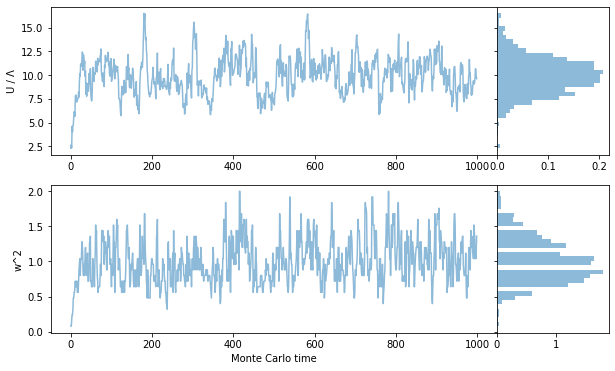

In [46]:
ax = plot(v)

In [47]:
with h5.File(storage, 'a') as f:
    v.to_h5(f.create_group(f'ensemble/{kappa=}'))

With the ensemble and an estimate for the autocorrelation we can thermalize and decorrelate.

In [48]:
v_independent = v.cut(10*autocorrelation).every(5*autocorrelation)
# 10 and 3 are chosen to be 'large' so that the the resulting samples are independent.
# We can calculate the autocorrelation time for the thermalized and decimated samples
independent_autocorrelation = max([
    supervillain.analysis.autocorrelation_time(o)
    for o in (v_independent.InternalEnergyDensity, v_independent.WindingSquared)])
print(independent_autocorrelation)

2


We can visualize the original and decorrelated samples,

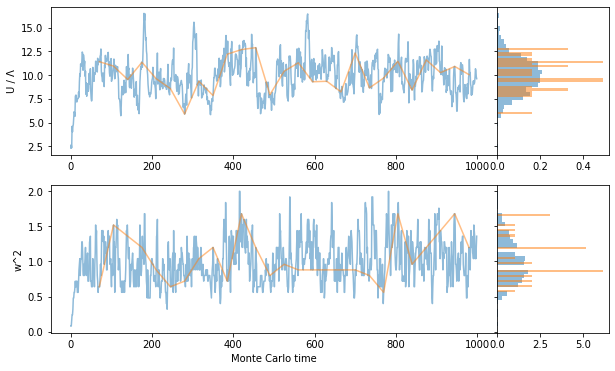

In [49]:
ax = plot(v)
ax = plot(v_independent, ax)

Now, with independent samples we can perform bootstrap estimates.

In [50]:
b = supervillain.analysis.Bootstrap(v_independent, bootstrap_resampling)

We can just print them prettily

In [51]:
print(f'S/Λ    {error_format(bootstrap_estimate(b.InternalEnergyDensity))}')
print(f'dn^2   {error_format(bootstrap_estimate(b.WindingSquared))}')

S/Λ    10.142 ± 0.300
dn^2   1.064 ± 0.069


or draw the estimates as uncertainty bands

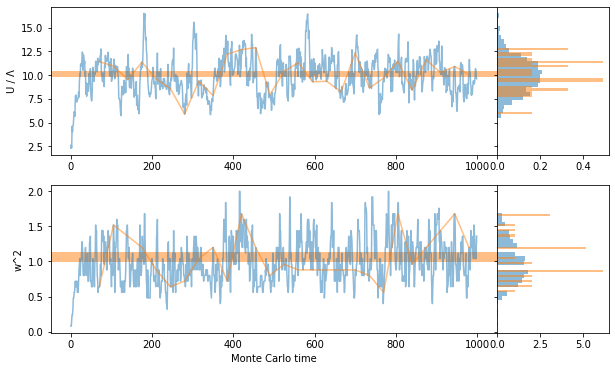

In [52]:
ax = plot(v)
ax = plot(v_independent, ax)

band(ax[0,0], bootstrap_estimate(b.InternalEnergyDensity))
band(ax[1,0], bootstrap_estimate(b.WindingSquared))

In [53]:
with h5.File(storage, 'a') as f:
    b.to_h5(f.create_group(f'/bootstrap/{kappa=}'))

# Worldline Formulation

The Worldline formulation is best when κ is big.  Since κ lives downstairs in the action, a big κ allows easier transitions and yields more likely acceptance for proposals.

In [54]:
kappa = 1.0
S = supervillain.action.Worldline(L, kappa)
p = supervillain.generator.constraint.PlaquetteUpdate(S)
h = supervillain.generator.constraint.HolonomyUpdate(S)

G = supervillain.generator.combining.Sequentially((p, h))  
w = supervillain.Ensemble(S).generate(configurations, G, start='cold', progress=tqdm)

  0%|          | 0/999 [00:00<?, ?it/s]

In [55]:
print(G.report())
print(f'S/Λ    {error_format(naive_estimate(w.InternalEnergyDensity))}')
print(f'dn^2   {error_format(naive_estimate(w.WindingSquared))}')

autocorrelation = max([
    supervillain.analysis.autocorrelation_time(o)
    for o in (w.InternalEnergyDensity, w.WindingSquared,
              # Holonomies:
              w.configurations.m[:,0].sum(axis=2).sum(axis=1),
              w.configurations.m[:,1].sum(axis=2).sum(axis=1),
             )])

print(f'τ      {autocorrelation}')

There were 8087 single-plaquette proposals accepted of 25000 proposed updates.
    0.323480 acceptance rate
    0.322989 average Metropolis acceptance probability.

There were 2656 single-holonomy proposals accepted of 10000 proposed updates.
    0.265600 acceptance rate
    0.261564 average Metropolis acceptance probability.
S/Λ    0.471 ± 0.005
dn^2   -0.002 ± 0.001
τ      2


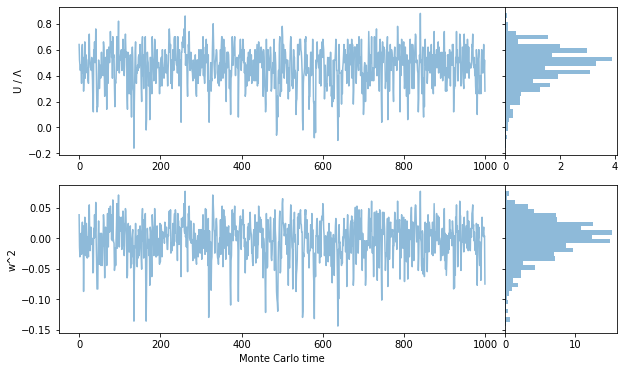

In [56]:
ax = plot(w)

In [57]:
with h5.File(storage, 'a') as f:
    w.to_h5(f.create_group(f'ensemble/{kappa=}'))

With the ensemble and an estimate for the autocorrelation we can thermalize and decorrelate.

In [58]:
w_independent = w.cut(10*autocorrelation).every(5*autocorrelation)
# 10 and 5 are chosen to be 'large'.
# We can calculate the autocorrelation time for the thermalized and decimated samples
independent_autocorrelation = max([
    supervillain.analysis.autocorrelation_time(o)
    for o in (w_independent.InternalEnergyDensity, w_independent.WindingSquared)])
print(independent_autocorrelation)

1


We can visualize the original and decorrelated samples,

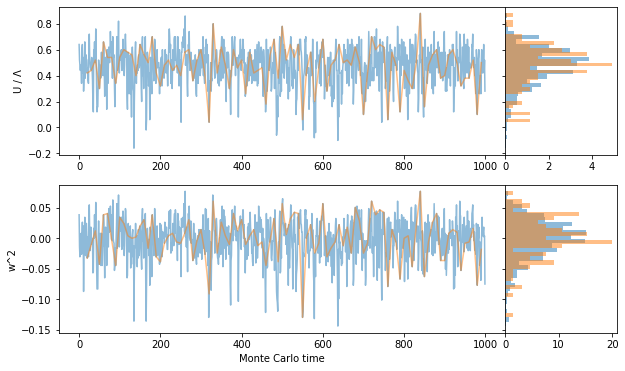

In [59]:
ax = plot(w)
ax = plot(w_independent, ax=ax)

Now, with independent samples we can perform bootstrap estimates.

In [60]:
b = supervillain.analysis.Bootstrap(w_independent, bootstrap_resampling)

We can just print them prettily

In [61]:
print(f'S/Λ    {error_format(bootstrap_estimate(b.InternalEnergyDensity))}')
print(f'dn^2   {error_format(bootstrap_estimate(b.WindingSquared))}')

S/Λ    0.476 ± 0.016
dn^2   0.000 ± 0.003


or draw the estimates as uncertainty bands

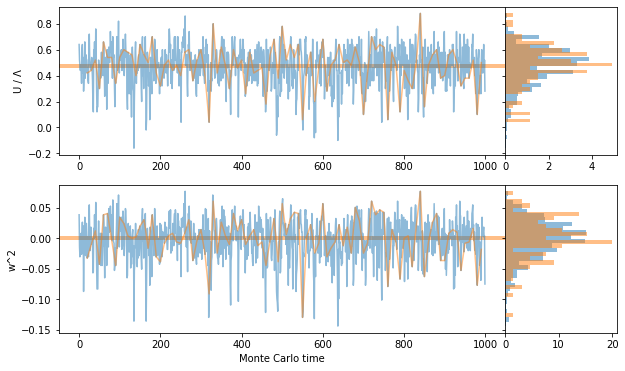

In [62]:
ax = plot(w)
ax = plot(w_independent, ax=ax)

band(ax[0,0], bootstrap_estimate(b.InternalEnergyDensity))
band(ax[1,0], bootstrap_estimate(b.WindingSquared))

In [63]:
with h5.File(storage, 'a') as f:
    b.to_h5(f.create_group(f'/bootstrap/{kappa=}'))

# Comparison

Since we wrote both bootstraps to disk we can read them in and compare some observables.

(Of course, we should take the continuum / infinite-volume limit to have a truly fair comparison between different κs!)

In [64]:
with h5.File(storage, 'r') as f:
    V = supervillain.analysis.Bootstrap.from_h5(f[f'/bootstrap/kappa=0.1'])
    W = supervillain.analysis.Bootstrap.from_h5(f[f'/bootstrap/kappa=1.0'])

We (approximately) know κ critical

In [65]:
kappa_critical = 0.740

and can draw it on our figures.

Text(0.5, 0, '1/κ')

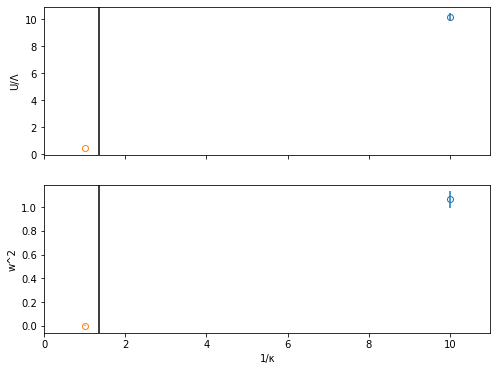

In [66]:
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex='col')

style = {'marker': 'o', 'markerfacecolor': 'none'}

ax[0].errorbar([1/0.1,], *bootstrap_estimate(V.InternalEnergyDensity), **style)
ax[0].errorbar([1/1.0,], *bootstrap_estimate(W.InternalEnergyDensity), **style)

ax[1].errorbar([1/0.1,], *bootstrap_estimate(V.WindingSquared), **style)
ax[1].errorbar([1/1.0,], *bootstrap_estimate(W.WindingSquared), **style)

ax[0].set_xlim(0, 11)

for a in ax:
    a.axvline(1/kappa_critical, color='black')

ax[0].set_ylabel('U/Λ')
ax[1].set_ylabel('w^2')
ax[-1].set_xlabel('1/κ')